In [1]:
from Pipeline import BLEPipeline, WifiPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# ML libraries
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, roc_auc_score

# System libraries
from itertools import izip, combinations
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create dataset

In [2]:
time_start = time.time()

In [3]:
w = WifiPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = w.make_dataframe()

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64


## Resample

### Downsampling

In [6]:
# Take out packets from router
df = df[df["DeviceType"]!="router"]

df_train = df[df['Set']=='train']

# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'SourceAddr', 'Set', 'SubtypeNum'}
onehotEncoded_vars = {'Belkin', 'Data', 'Dropcam', 
                      'Lifi', 'Netgear', 'QoS_Data', 'QoS_Null', 'Tp-link'}
response_vars = {"DeviceType","bulb","camera","router","plug"}

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | set(['Subtype', 'Vendor'])
X = df_train.drop(col_drop, axis=1)

In [7]:
df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

### Create trial dataframes

In [8]:
df_trials = []

for i in range(0,10):
    df_downsampled = w.downsample(X, y, df[df["Set"]=="test"])
    df_trials.append(df_downsampled)

In [9]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength", "Time",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["camera", "bulb", "plug"]

# Run trials

In [10]:
df_results = []
for i, trial in enumerate(df_trials):
    print "Trial", i
    result = w.one_vs_all_classify(trial, features_list, y_list)
    df_results.append(result)

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


## Reports/Plots

In [11]:
w.create_csv_results('wifi', df_results)

In [12]:
device_types = ['bulb', 'camera', 'plug']
classifiers = ['KNN', 'LDA', 'RF']

### AUC

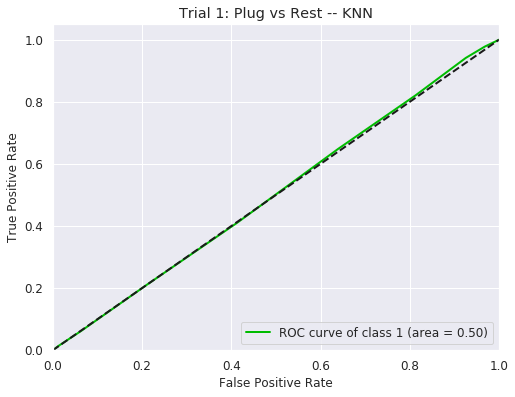

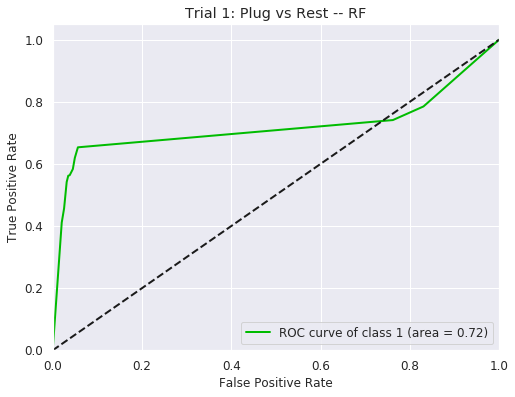

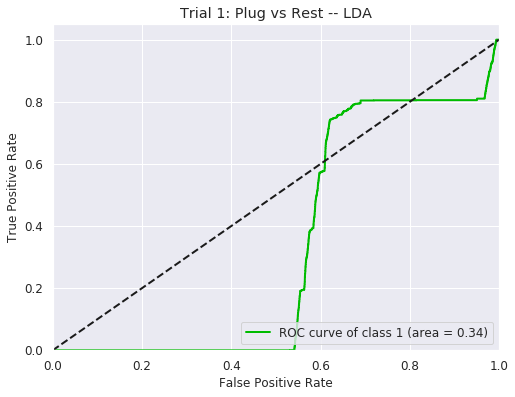

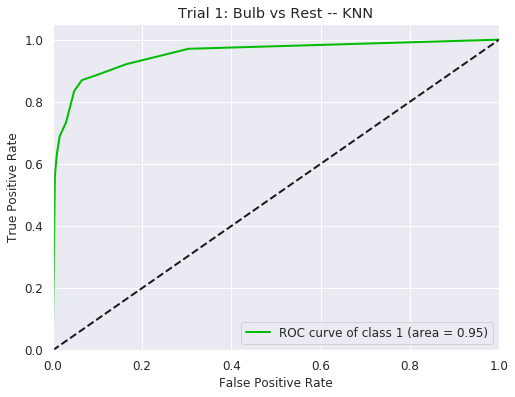

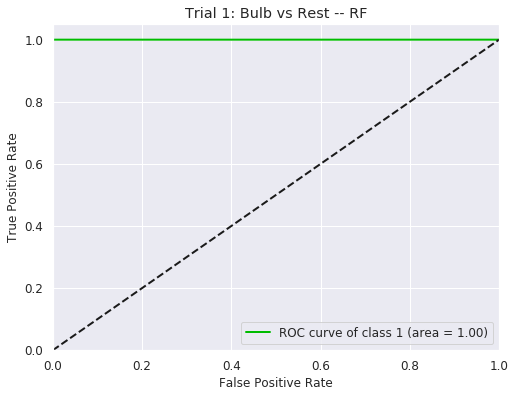

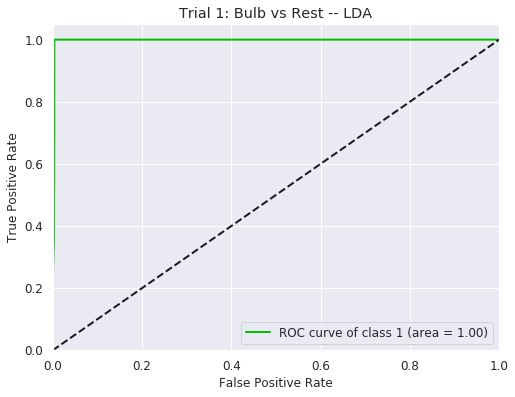

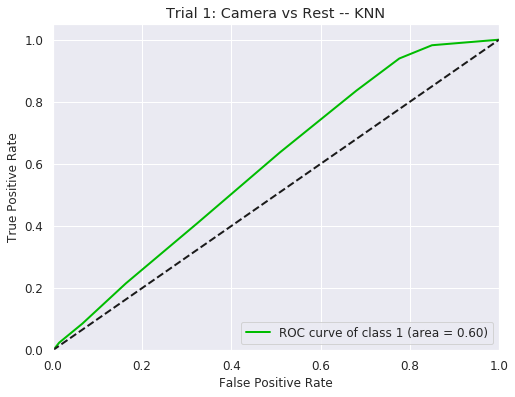

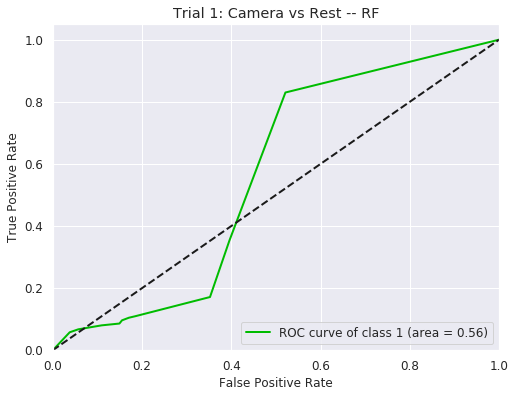

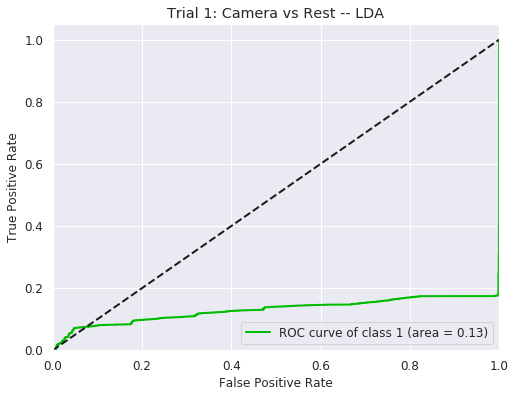

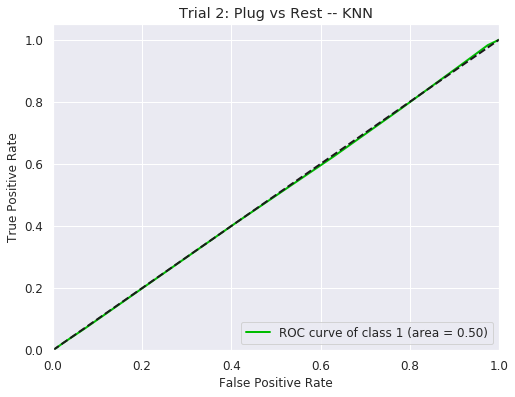

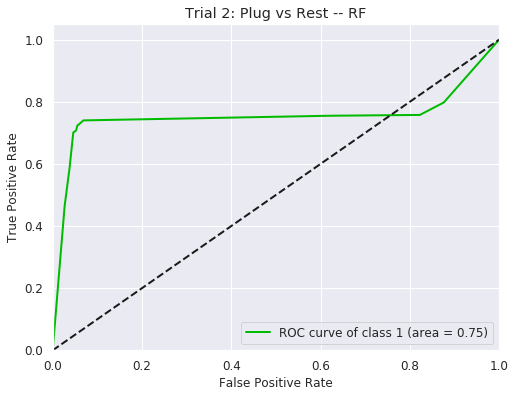

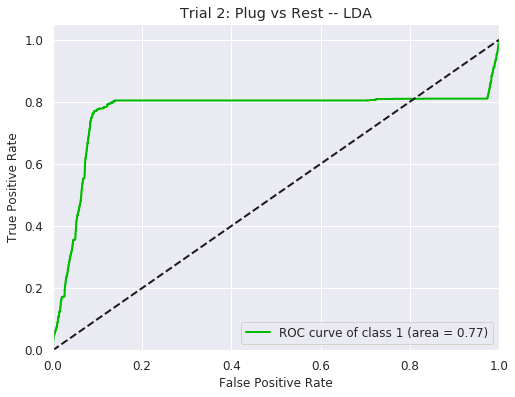

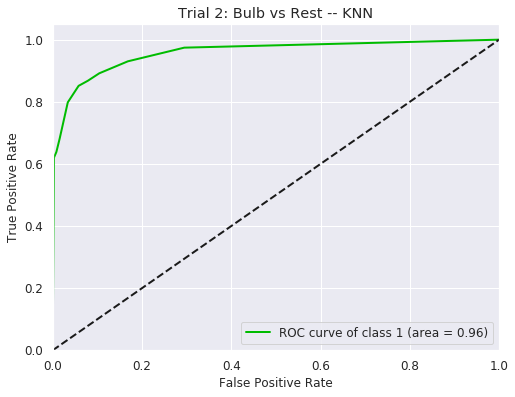

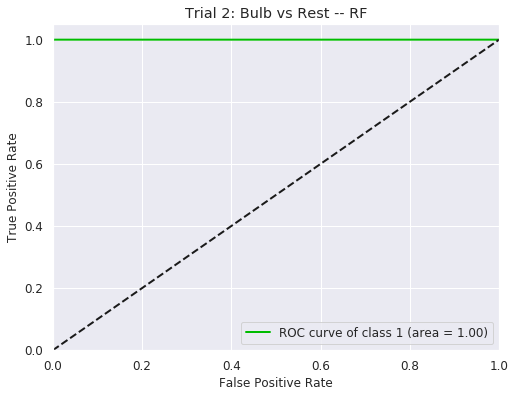

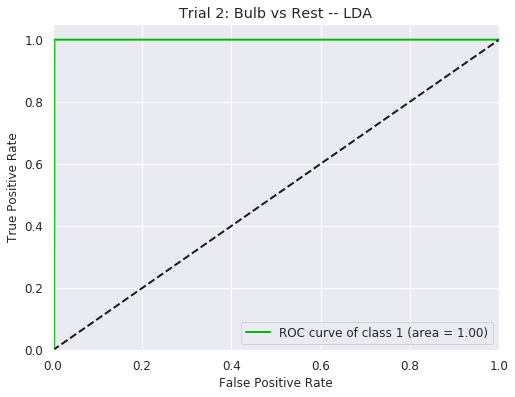

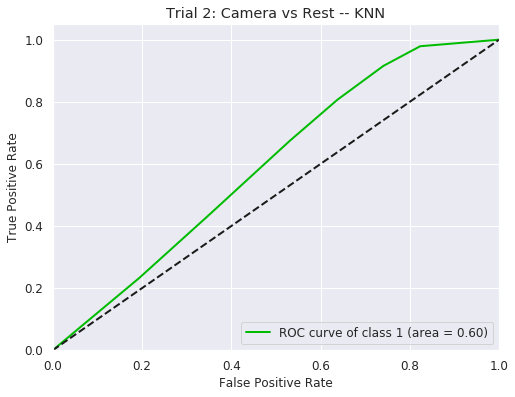

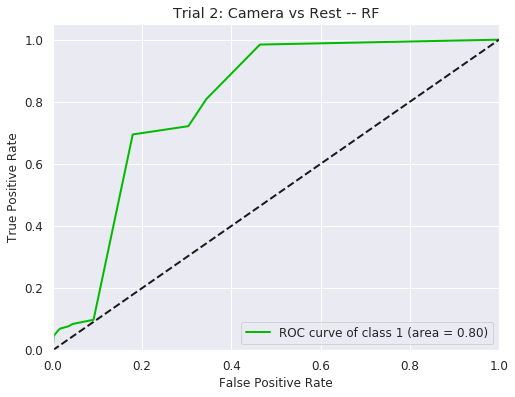

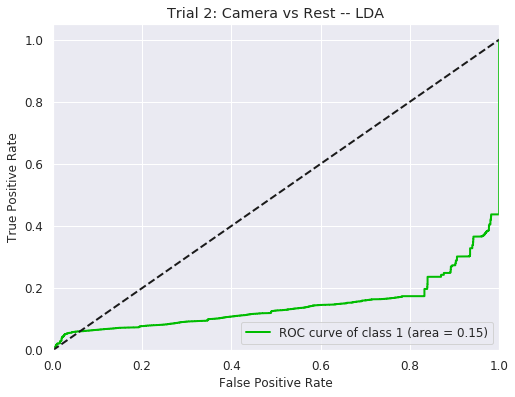

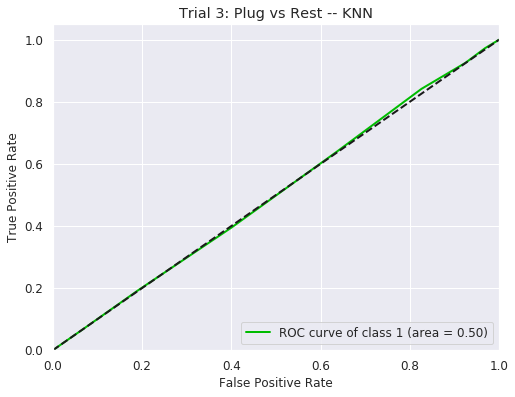

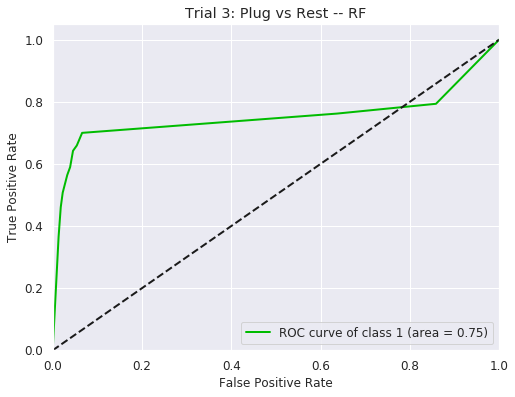

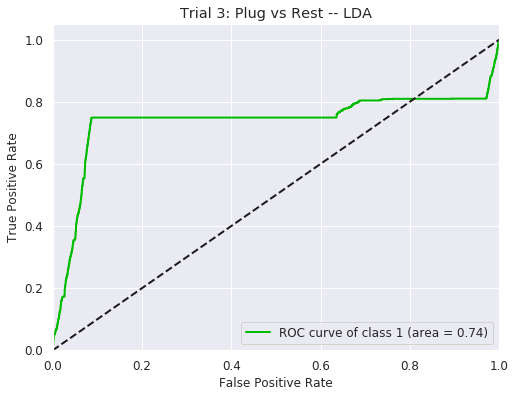

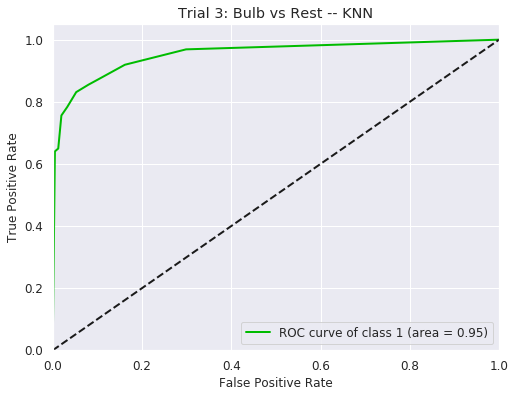

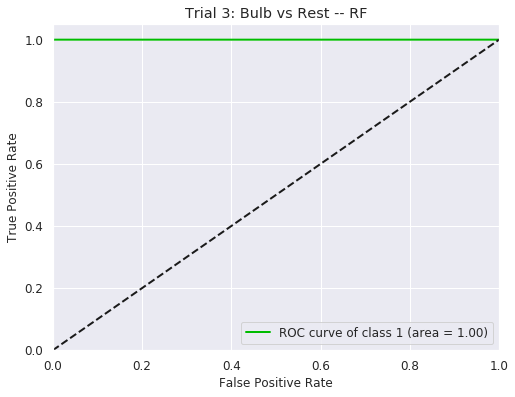

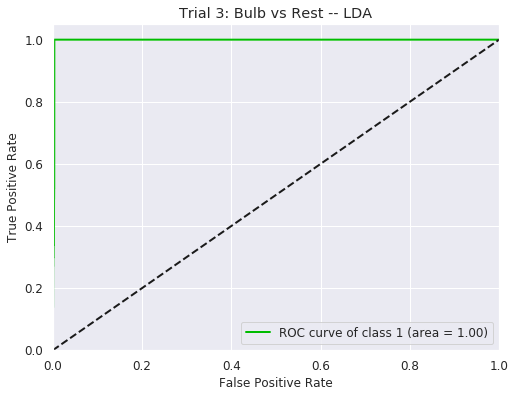

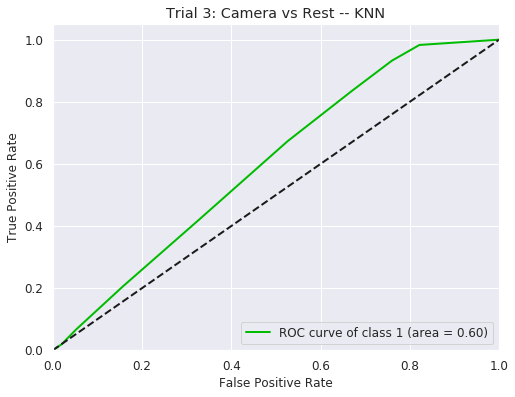

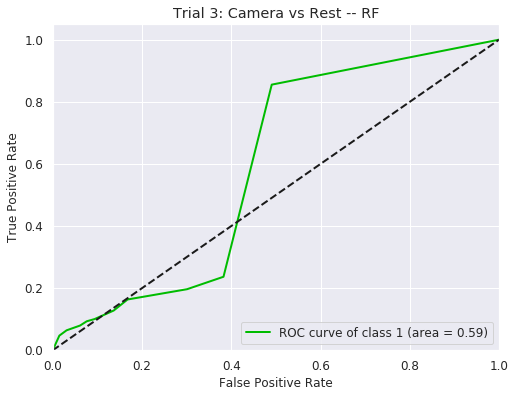

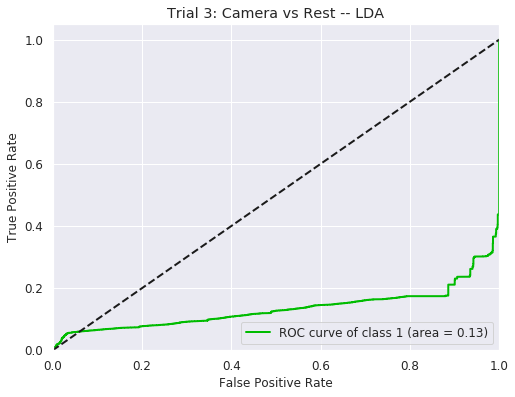

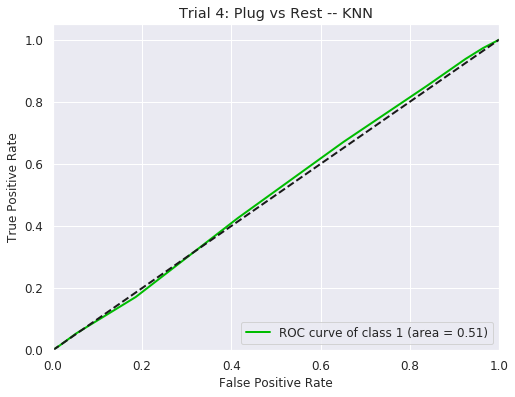

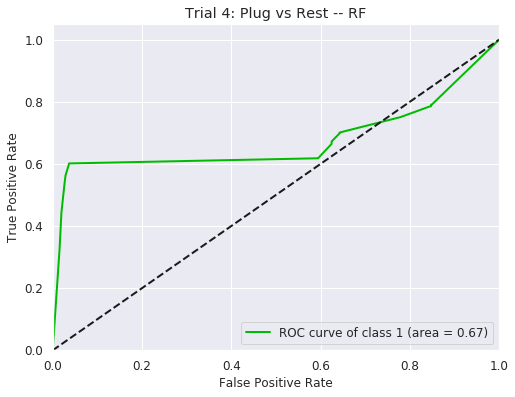

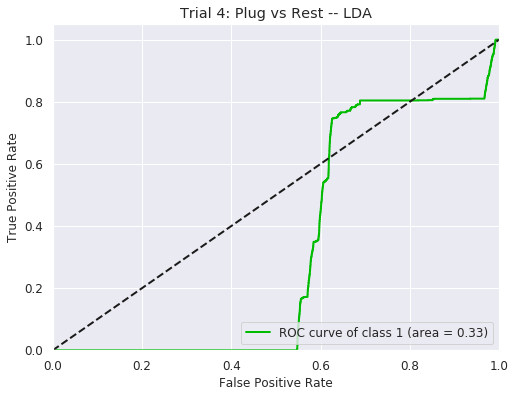

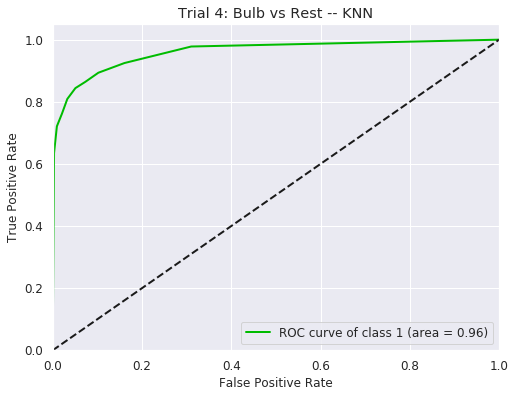

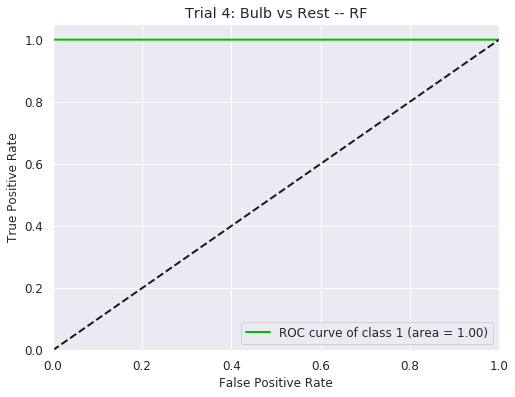

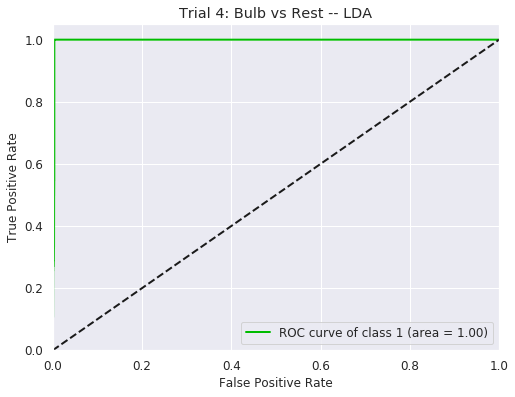

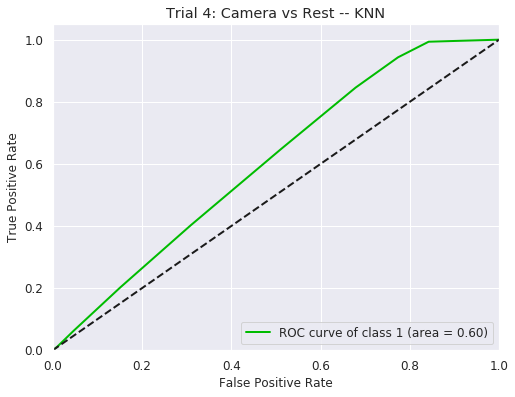

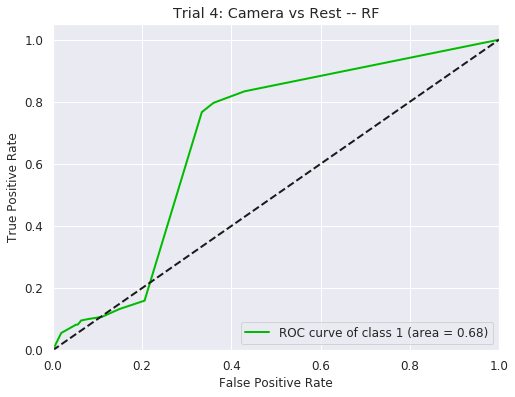

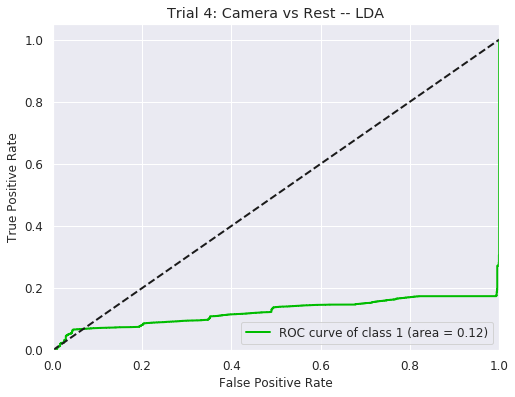

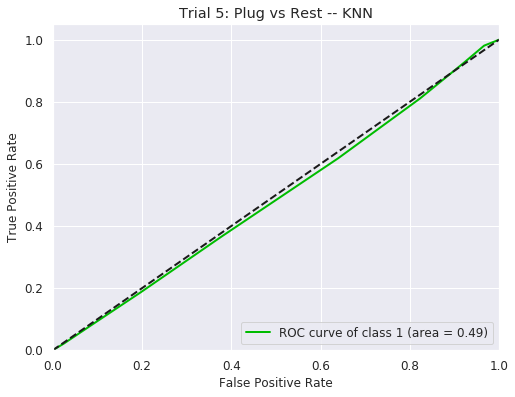

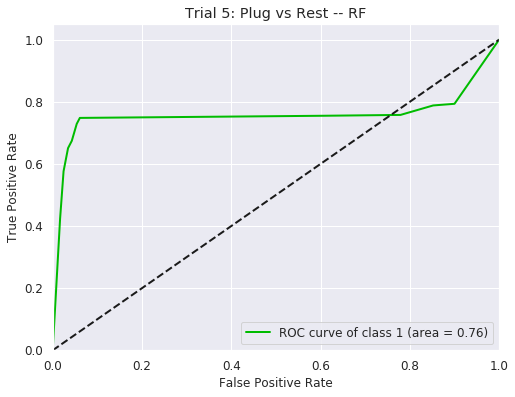

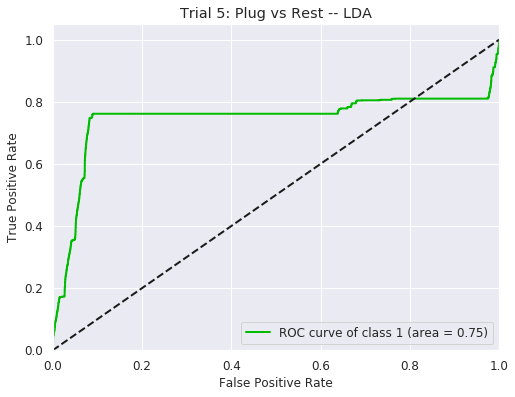

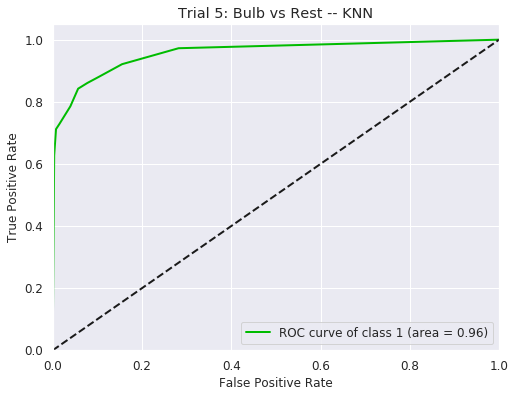

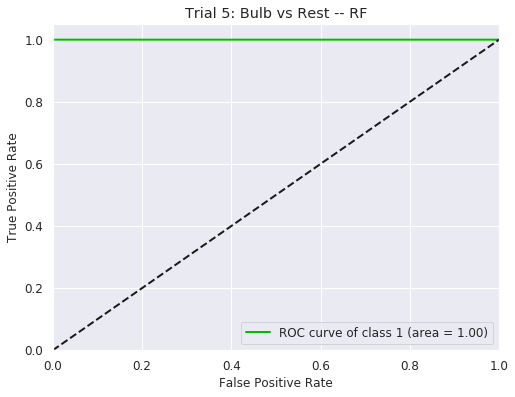

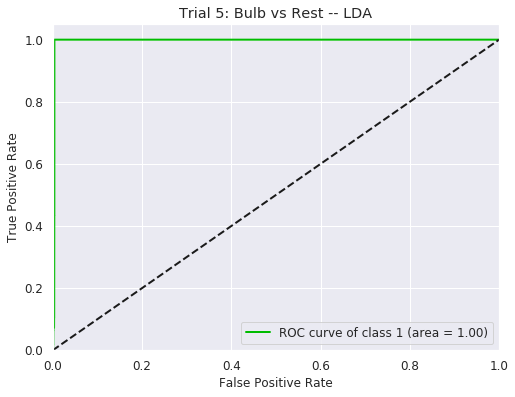

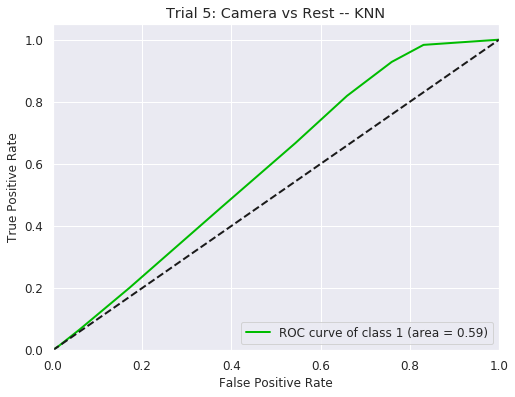

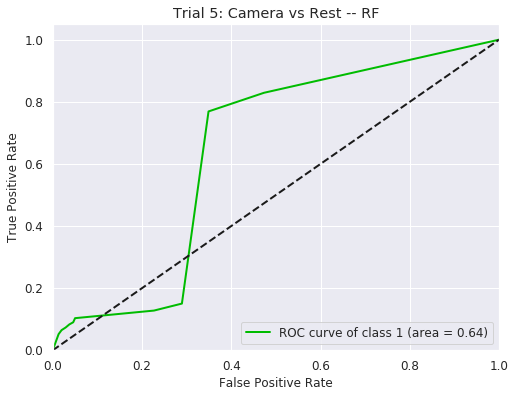

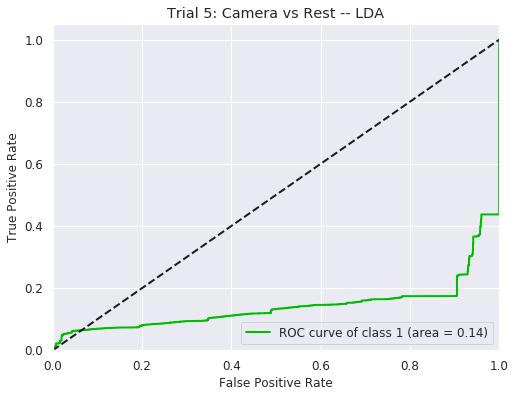

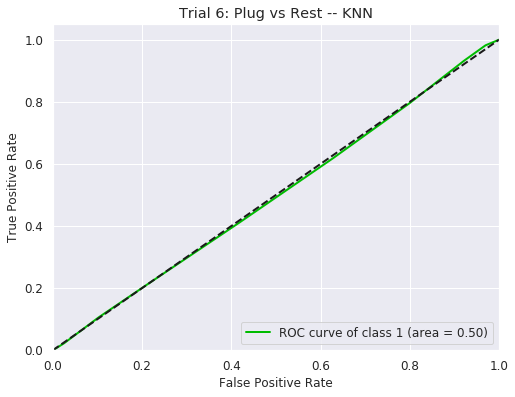

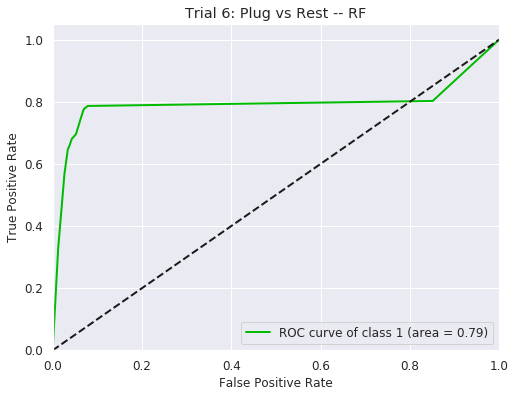

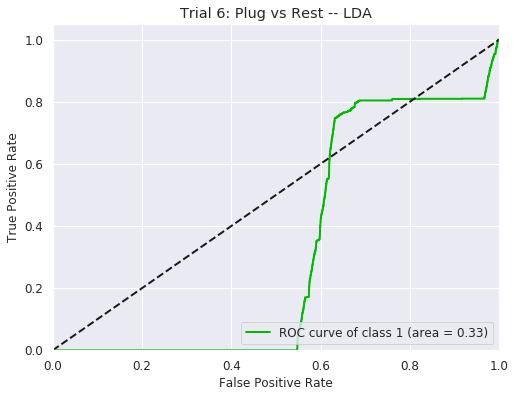

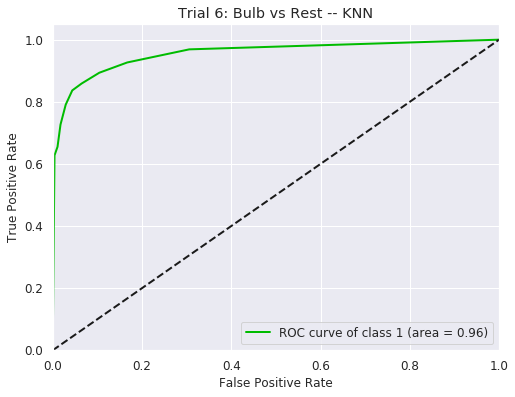

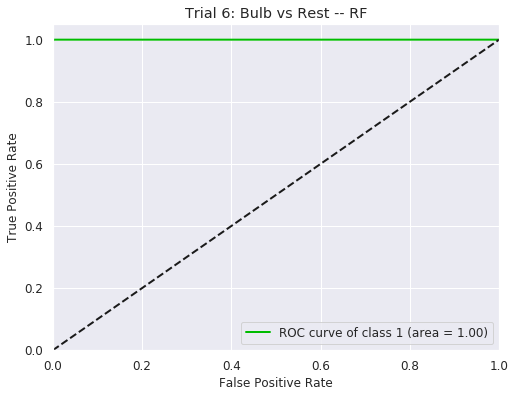

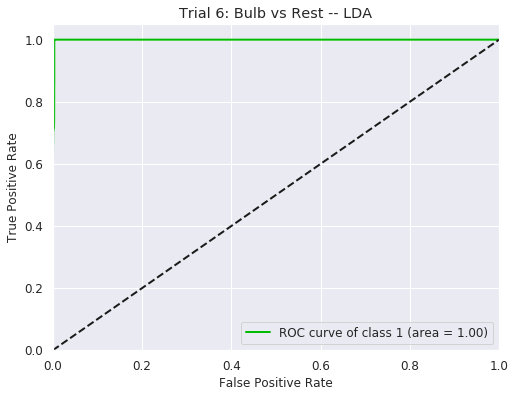

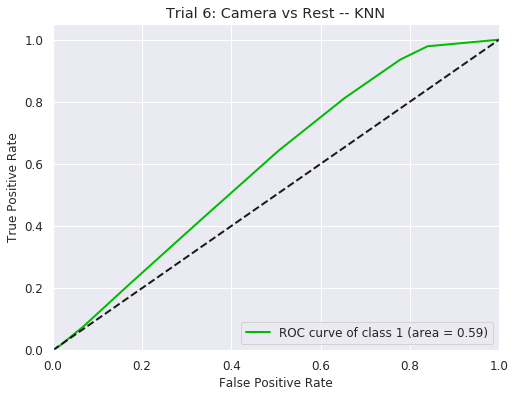

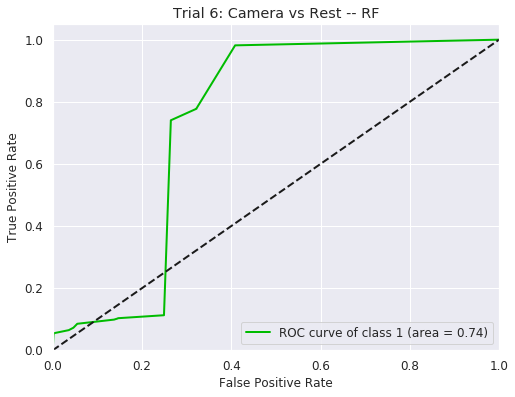

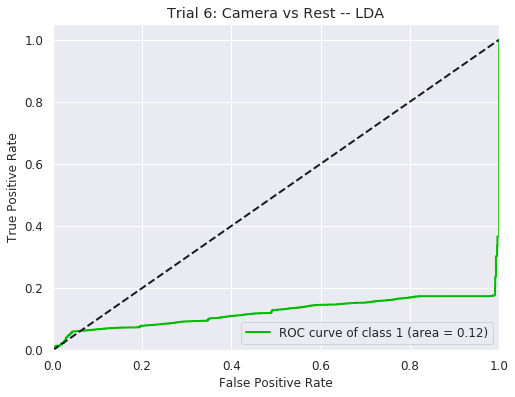

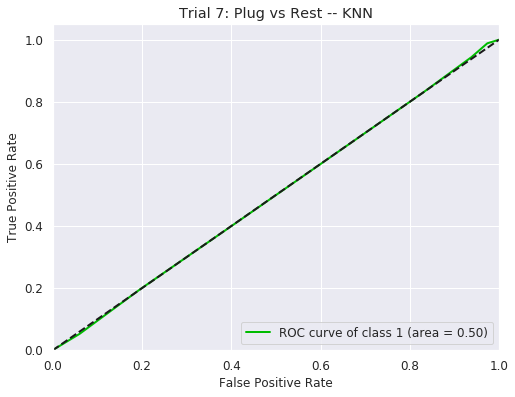

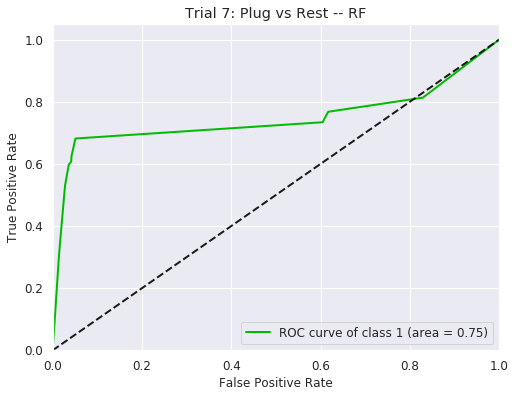

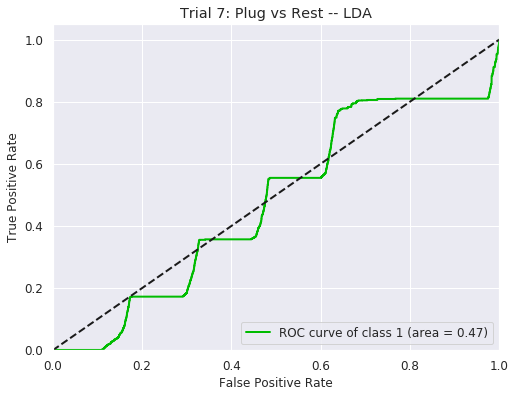

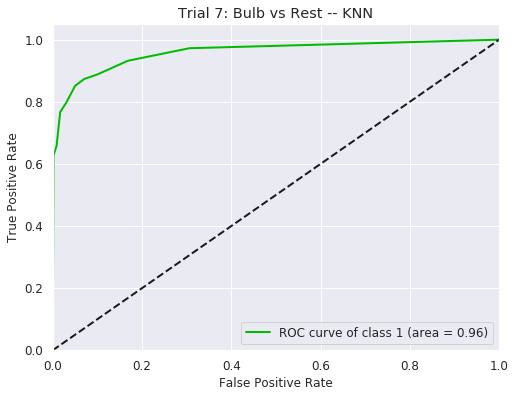

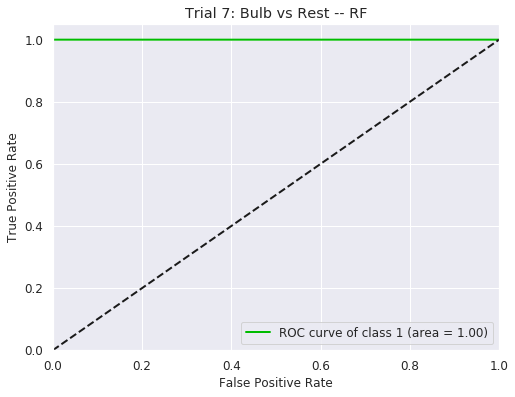

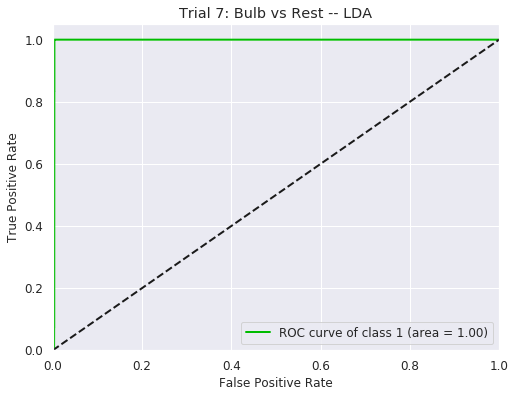

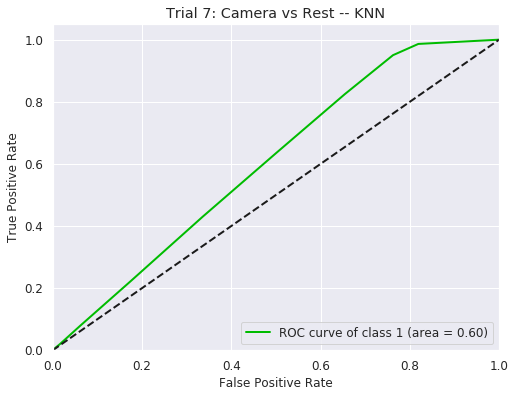

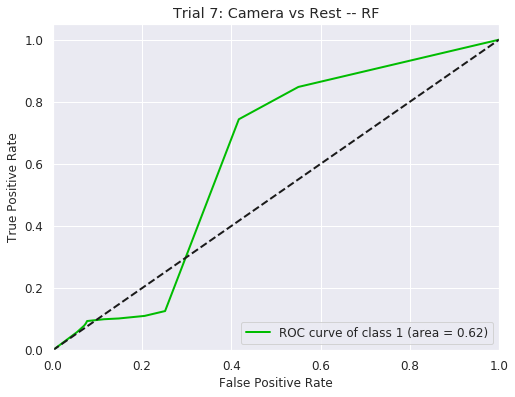

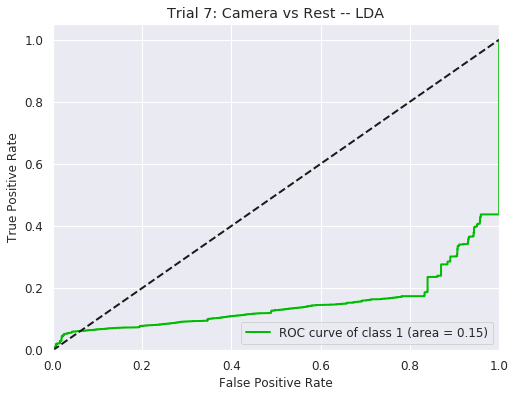

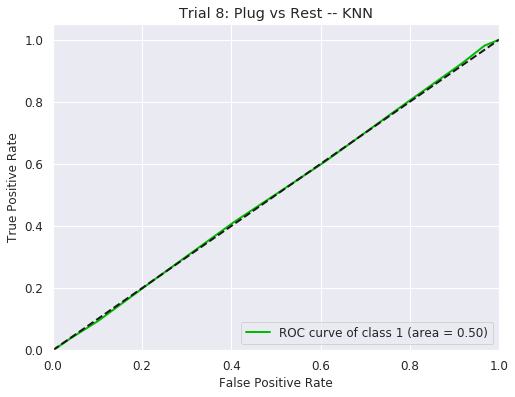

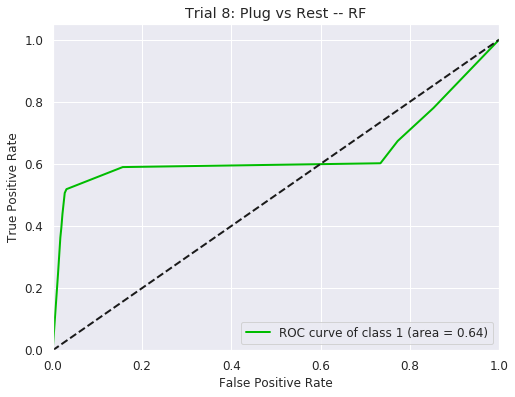

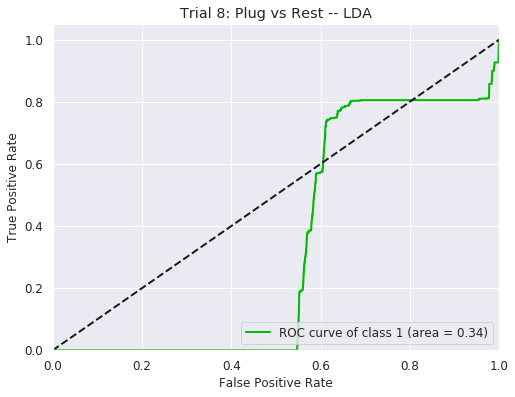

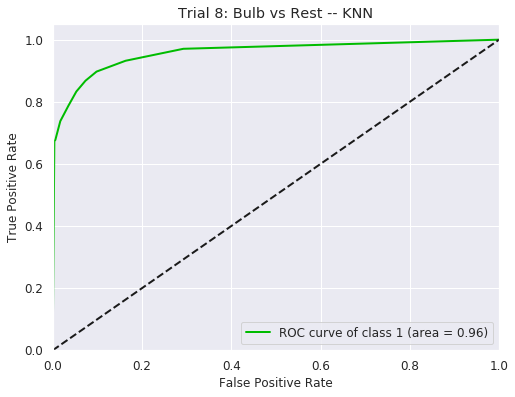

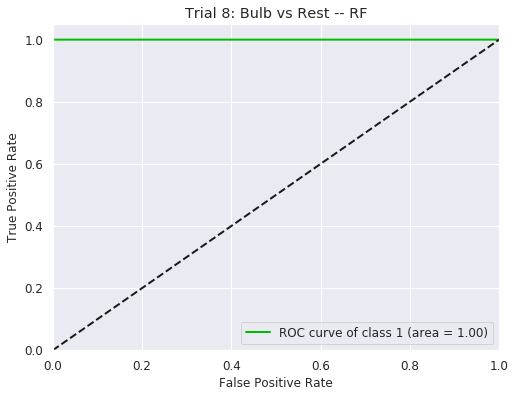

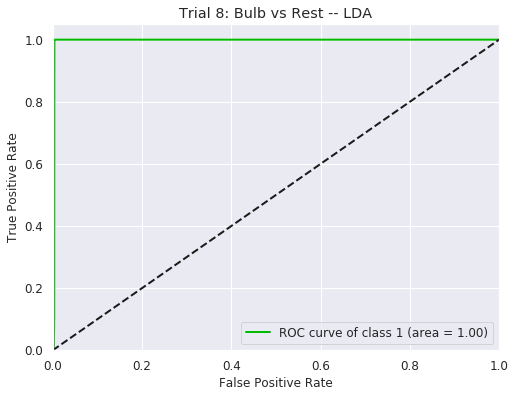

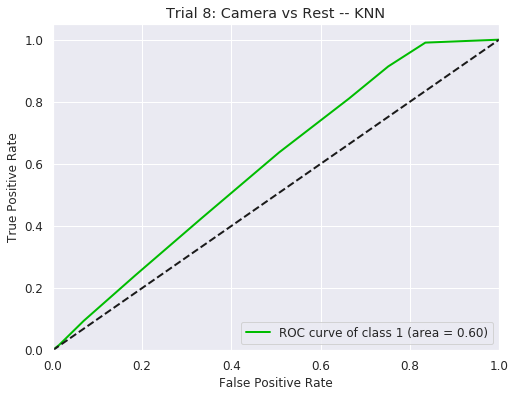

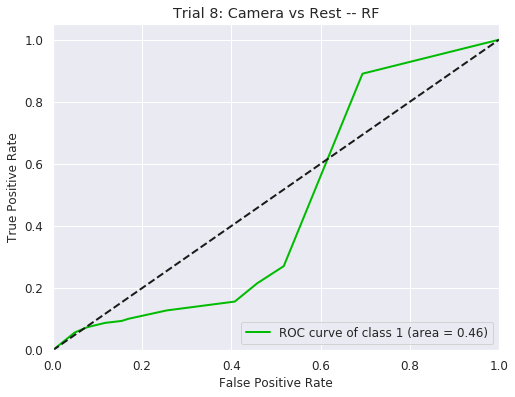

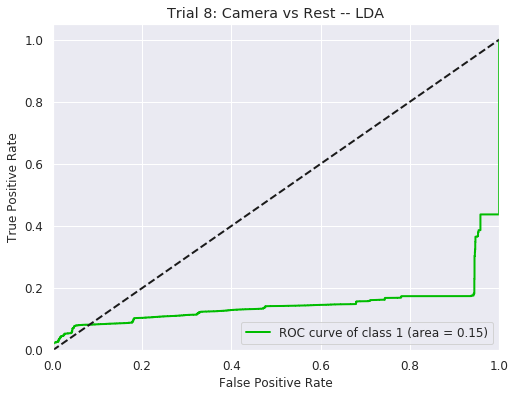

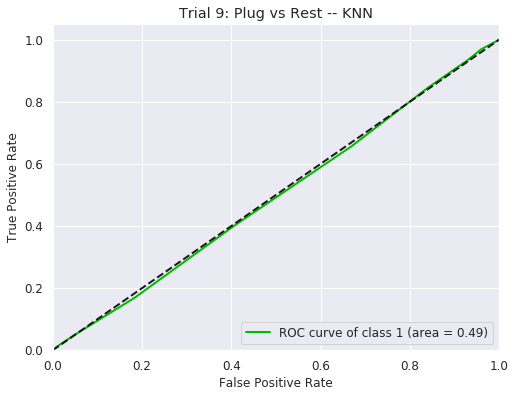

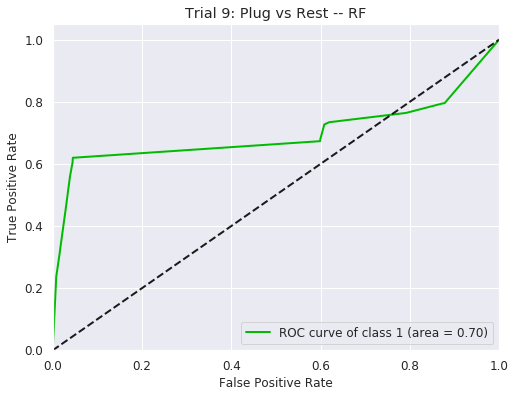

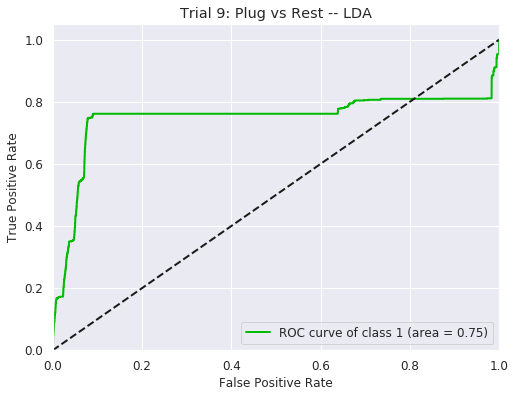

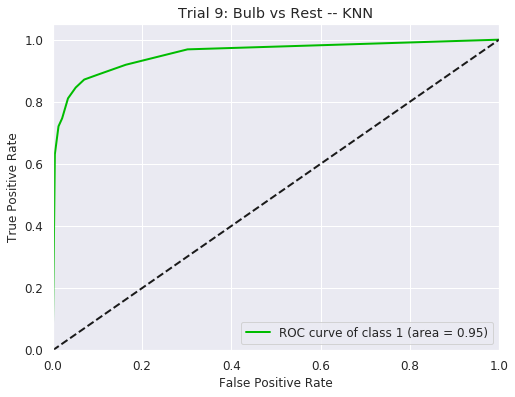

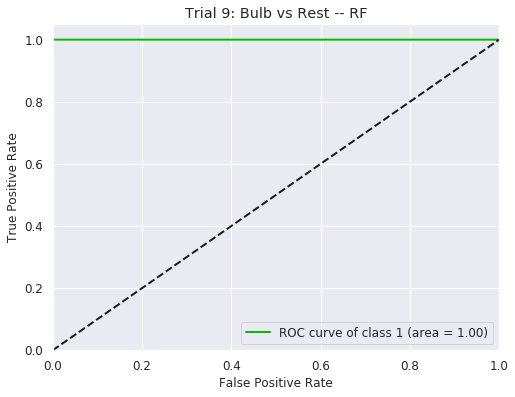

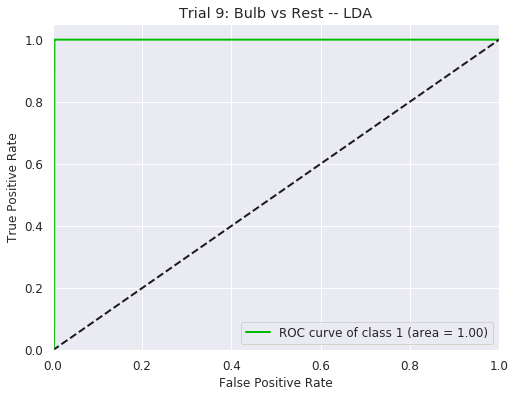

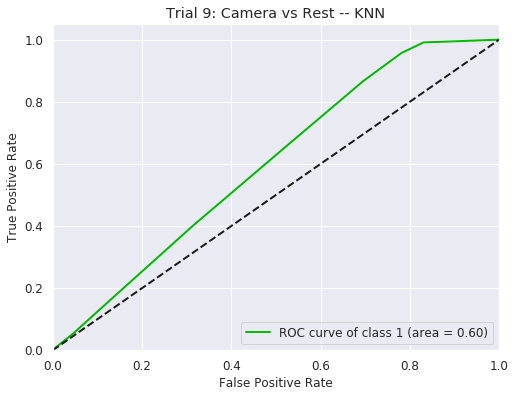

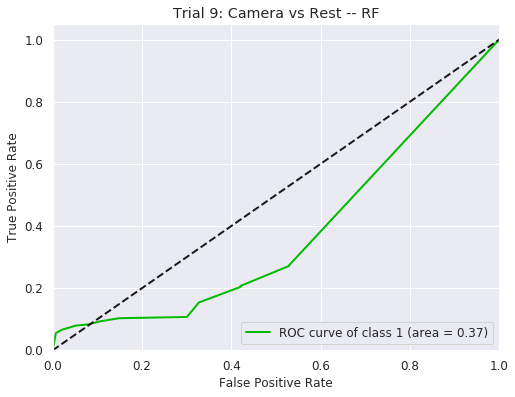

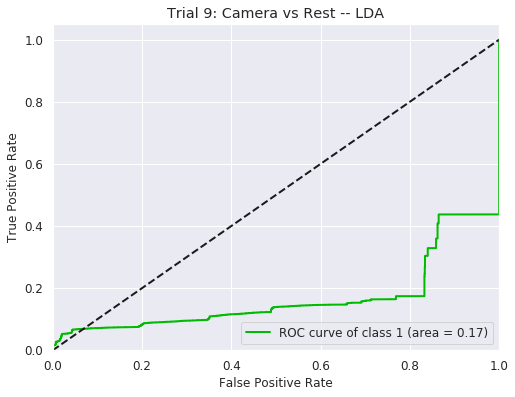

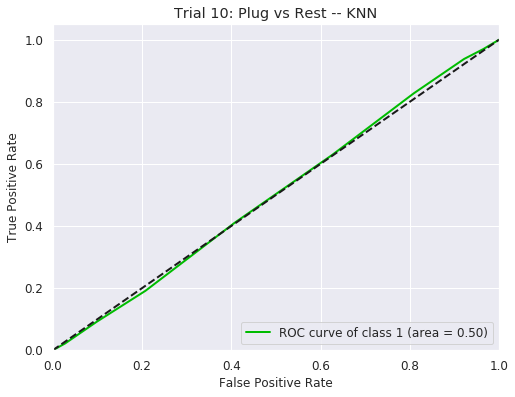

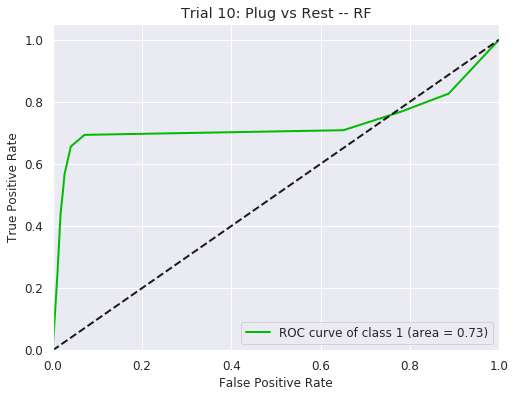

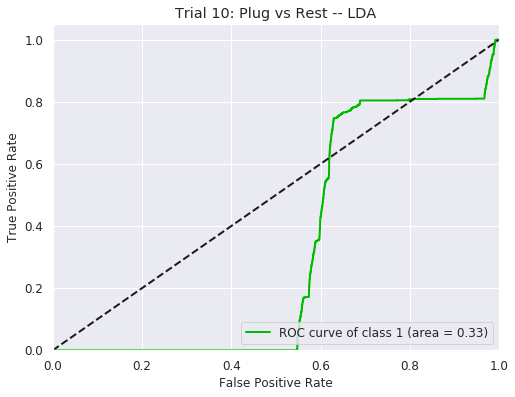

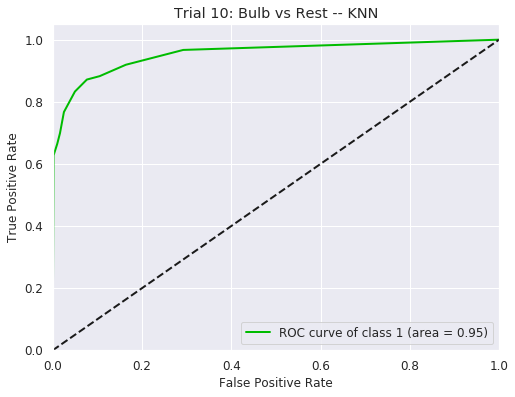

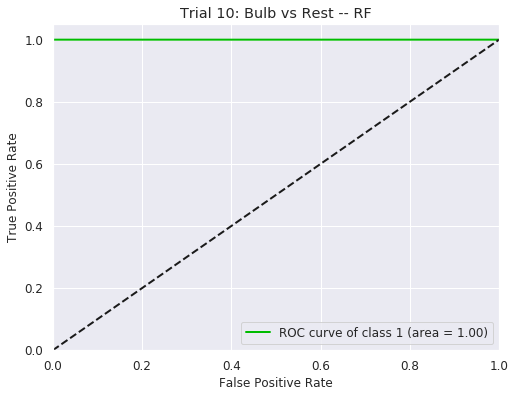

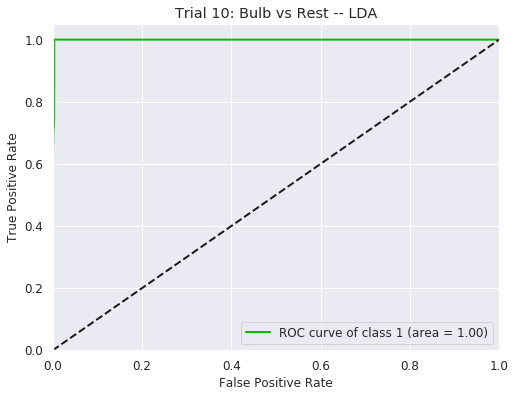

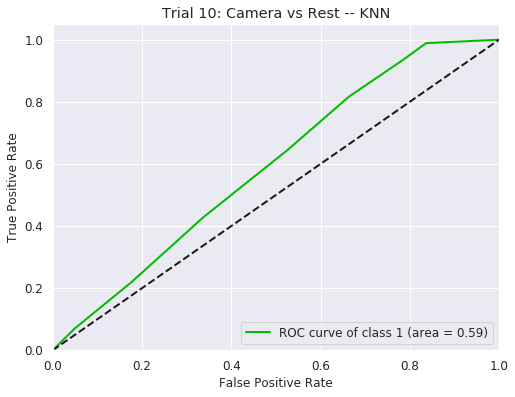

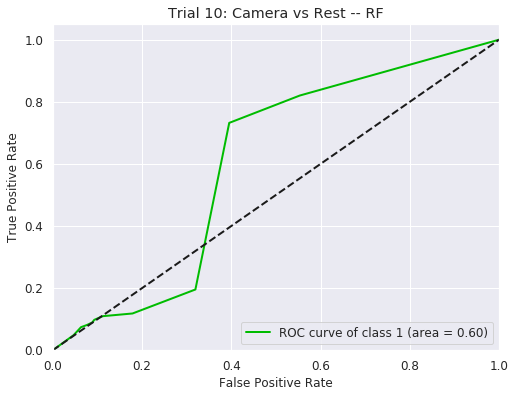

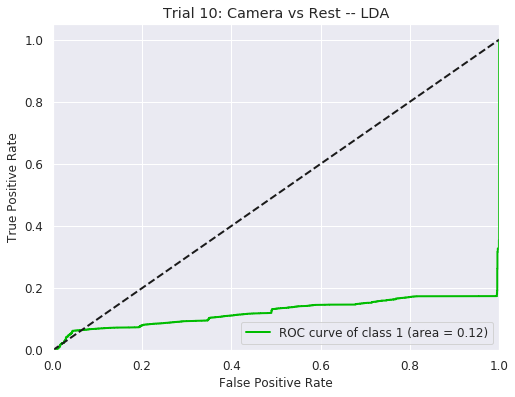

In [13]:
# Plotting ROC curves
sns.set(font_scale=1)

for trial_num, result in enumerate(df_results):
    # Extract devices and classifiers
    dev_pairs = result[0].keys()
    classifiers = result[0][dev_pairs[0]].keys()

    for device in dev_pairs:
        for classifier in classifiers:
            # Extract predicted probas and y_true
            pred_proba = result[0][device][classifier]['Classifier']['Pred_Proba']
            true = result[0][device][classifier]['Classifier']['True']

            # Plot ROC curve
            fpr, tpr, threshold = roc_curve(true, pred_proba[:,1], pos_label=1)
            auc = roc_auc_score(true, pred_proba[:,1])
            title = "Trial " + str(trial_num + 1) + ": " + str(device).capitalize() + " vs Rest -- " + str(classifier).upper() 
            skplt.metrics.plot_roc(true, pred_proba, title=title, plot_micro=False, plot_macro=False, 
                                   classes_to_plot=[1], figsize=(8,6));

### Time Performance

In [14]:
for trial_num, result in enumerate(df_results):
    print "Trial ", trial_num
    print "Total time:", result[1], "seconds"
    
    for device in device_types:
        for classifier in classifiers:
            title = "("+ str(device).capitalize() + ", "+str(classifier).upper() + ")"
            print title, ":", result[0][device][classifier]['Classifier']['Time'], "seconds"
    
    print ""

Trial  0
Total time: 1.81902599335 seconds
(Bulb, KNN) : 0.246201992035 seconds
(Bulb, RF) : 0.0735228061676 seconds
(Bulb, LDA) : 0.00965213775635 seconds
(Camera, KNN) : 0.293339014053 seconds
(Camera, RF) : 0.0939671993256 seconds
(Camera, LDA) : 0.0103590488434 seconds
(Plug, KNN) : 0.272150039673 seconds
(Plug, RF) : 0.0831580162048 seconds
(Plug, LDA) : 0.0149760246277 seconds

Trial  1
Total time: 1.82058095932 seconds
(Bulb, KNN) : 0.260046005249 seconds
(Bulb, RF) : 0.0734379291534 seconds
(Bulb, LDA) : 0.0105488300323 seconds
(Camera, KNN) : 0.247387886047 seconds
(Camera, RF) : 0.101795196533 seconds
(Camera, LDA) : 0.00938987731934 seconds
(Plug, KNN) : 0.243237018585 seconds
(Plug, RF) : 0.0735859870911 seconds
(Plug, LDA) : 0.0109241008759 seconds

Trial  2
Total time: 1.81193900108 seconds
(Bulb, KNN) : 0.252990007401 seconds
(Bulb, RF) : 0.0935151576996 seconds
(Bulb, LDA) : 0.0107069015503 seconds
(Camera, KNN) : 0.255445957184 seconds
(Camera, RF) : 0.0798590183258 se

### Feature Importance

In [15]:
df_featImp = pd.DataFrame()
for i,f in enumerate(w.feature_importances):
    f_i = pd.Series(f, index=features_list)
    df_featImp[i] = f_i

In [16]:
import numpy as np, scipy.stats as st
a = df_featImp.iloc[:,0:30].T
lower, upper = st.t.interval(0.90, len(a)-1, loc=np.mean(a), scale=st.sem(a))

/root/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/root/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [17]:
df_featImp['Mean'] = df_featImp.mean(axis=1)
df_featImp['StdDev'] = df_featImp.std(axis=1)
df_featImp['CI_Lower'] = lower
df_featImp['CI_Upper'] = upper

In [18]:
display(df_featImp[['Mean', 'StdDev', 'CI_Lower', 'CI_Upper']].sort_values('Mean', ascending=False))

,Mean,StdDev,CI_Lower,CI_Upper
Belkin,0.216086,0.216122,0.147896,0.284277
PacketLength,0.213191,0.159031,0.163013,0.263368
Dropcam,0.171657,0.198504,0.109025,0.234289
Assoc_Packets,0.122545,0.086497,0.095253,0.149836
QoS_Null,0.116202,0.112557,0.080688,0.151716
Lifi,0.057182,0.069459,0.035266,0.079097
QoS_Data,0.047256,0.045379,0.032938,0.061574
Time,0.031440,0.016849,0.026123,0.036756
Data,0.014930,0.014544,0.010341,0.019519
Tp-link,0.009512,0.018615,0.003638,0.015385


### Sampling Counts

In [19]:
print "Packet Counts Prior to Resampling"
print df["DeviceType"].value_counts()

Packet Counts Prior to Resampling
plug      85512
camera    71399
bulb       1231
Name: DeviceType, dtype: int64


Training Set plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64

Test Set camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


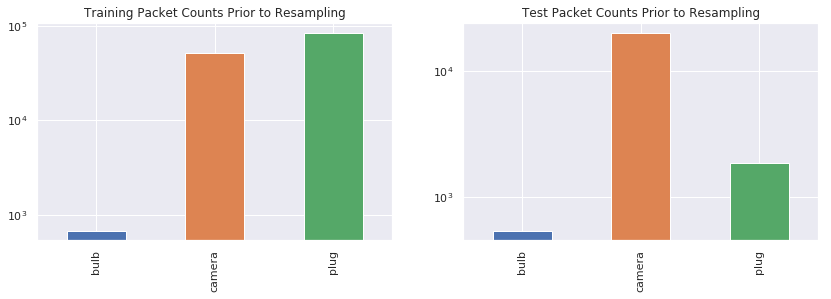

In [20]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling", logy=True);
print "Training Set", df_train["DeviceType"].value_counts()
print

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling", logy=True);
print "Test Set", df_test["DeviceType"].value_counts()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


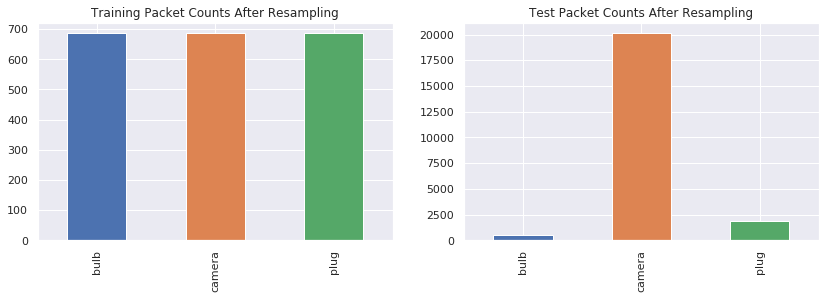

In [21]:
# Plot post-sampling
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

df_train_downsampled = df_trials[0][df_trials[0]['Set']=='train']
df_test_downsampled = df_trials[0][df_trials[0]['Set']=='test']

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[['bulb','camera','plug']].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");
